## cGAN convergence evaluation

This time, I applied some time-series inspired whitening by subtracting the *before* time-step from the *after* time step. I think the results are a decent start, but could use some hyperparameter tuning.

In [1]:
# get data from storage 
! gsutil cp gs://gdax-dnn-tmp-1/cgan-statistics.pkl .
! gsutil cp gs://gdax-dnn-tmp-1/cgan-model.h5 .

Copying gs://gdax-dnn-tmp-1/cgan-statistics.pkl...
/ [1 files][188.7 KiB/188.7 KiB]                                                
Operation completed over 1 objects/188.7 KiB.                                    
Copying gs://gdax-dnn-tmp-1/cgan-model.h5...
/ [1 files][587.8 KiB/587.8 KiB]                                                
Operation completed over 1 objects/587.8 KiB.                                    


In [2]:
# missing dependencies 
import sys
! pip install --user tensorflow
! pip install --user keras
sys.path.append('/home/jupyter/.local/lib/python3.5/site-packages')

     |████████████████████████████████| 421.8 MB 17 kB/s s eta 0:00:01
     |████████████████████████████████| 41 kB 4.0 kB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 57 kB 184 kB/s  eta 0:00:01
     |████████████████████████████████| 26.0 MB 40.0 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 104 kB 45.2 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 8.9 MB/s  eta 0:00:01
     |████████████████████████████████| 19.9 MB 47.9 MB/s eta 0:00:01    |▉                               | 552 kB 47.9 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 33.7 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=5680 sha256=70b94b1e5658af36d0cf180f2c84732c33ef92909bf9fd0961b41e081a3451ff
  Stored in directory: /home/jupyter/.cache/pip/wheels/91/0e/11/1f1321dce76e9c542907008e

In [4]:
import pickle
with open('cgan-statistics.pkl', 'rb') as f:
    stats = pickle.load(f)

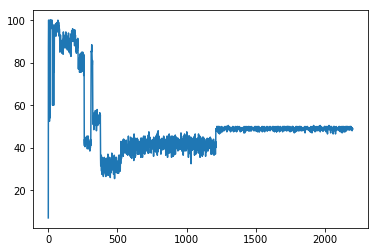

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stat(stat):
    plt.plot(stats[stat])
    plt.show()
    pass

plot_stat('acc')

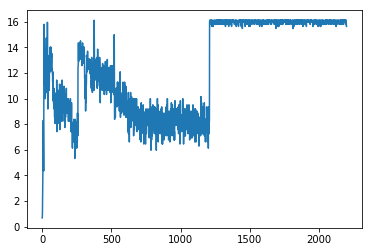

In [6]:
plot_stat('g_loss')

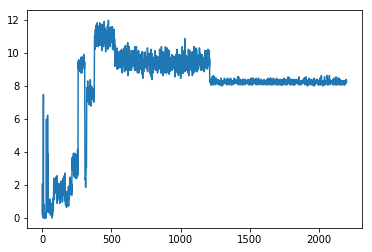

In [7]:
plot_stat('d_loss')

Convergence looks good. So, we'll finish this analysis with simulation histograms. 

In [8]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
import numpy as np

def build_generator(latent_dim=100, img_shape=(1024, 1), num_classes=3):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(256))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape)))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])
    img = model(model_input)
    return Model([noise, label], img)

gen = build_generator()
gen.load_weights('cgan-model.h5')

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024, 1)           0         
Total params: 145,536
Trainable params: 145,280
Non-trainable params: 256
_________________________________________________________________


In [9]:
def hist(x, num_bins=50, **kwargs):
    plt.hist(x, num_bins, **kwargs)
    plt.show()
    pass

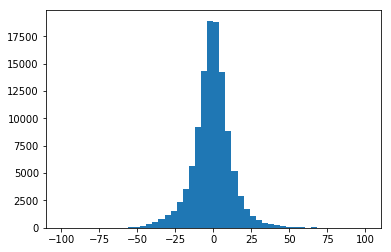

In [10]:
# Dead and not rewarded (0.4%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 0*np.ones(111)]).flatten()
hist(y,range=(-100,100))

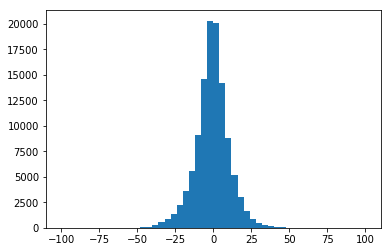

In [11]:
# Not dead and rewarded (3%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 1*np.ones(111)]).flatten()
hist(y,range=(-100,100))

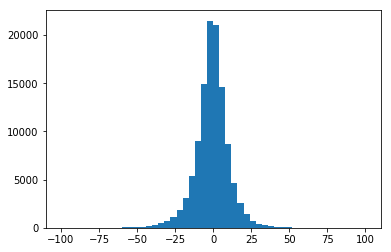

In [12]:
# Not dead and rewarded (96.6%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 2*np.ones(111)]).flatten()
hist(y,range=(-100,100))

In [13]:
! gsutil cp gs://gdax-dnn-tmp-1/cgan-data.pkl .

Copying gs://gdax-dnn-tmp-1/cgan-data.pkl...
- [1 files][  1.5 GiB/  1.5 GiB]   47.8 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [14]:
with open('cgan-data.pkl', 'rb') as f:
    cgan_data = pickle.load(f)

In [17]:
idx = np.random.choice(cgan_data[0].shape[0], 100)
x = cgan_data[0][idx,:]

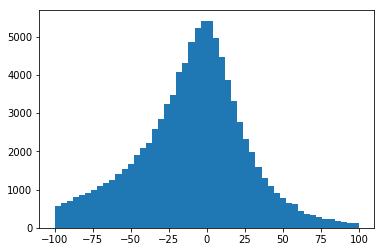

In [18]:
hist(x.flatten(), range=(-100, 100))